# Example evaluation of a recorded 3D nanoindentation tip

The basic class for evaluating 3D images is the `ImageData` class. It is best loading the data using the `from_txt()` class method specifying the input text file. Additionally used information is the type of measurement that was performed (e.g. `self_imaging`) and the unit of the input data. The input data needs to be a file containing three columns of the x, y and z coordinates of the individual measurement points. The text format is ideal when Gwyddion is used and the image exported as *.xyz*. Any additional arguments are passed to the `ImageData` constructor and include mostly metadata. Also, an output file can be specified where the evaluated data is saved. The output file is an hdf5 file. The output folder where any images are going to be saved is called 'results' by default. 

**One hint:** Unfortunately, the saving of the data is not optimally solved at the current state of the code. So it is safest to stick with the defaults and make a 'results' folder in the beginning. If you don't do that then you might end up with some errors during the saving of files. It is not a big deal to fix these errors on the fly but quite annyoing at least.

In [1]:
import os

import tipeval as te

input_file = '..\examples\self_imaging.xyz'

if not os.path.exists('results'):
    os.mkdir('results')

image = te.ImageData.from_txt(input_file, 'self_imaging', unit='m', output_file='output_example.h5')

In order to convert the data to a new unit you can use the `convert_data()` method of `ImageData`. By default the data is converted to nanometers. All available units are saved in the `TO_UNIT` dictionary.

In [2]:
image.convert_data(new_unit='nm')

It is important to close the file using the `close()` method. This closes the hdf5 file so that it can be modified externally. This is some unfortunate legacy necessity that should be removed in the future.  

In [3]:
image.close()

For plotting the image, the `ImagePlot` class is available. It has a class method `from_hdf()` which can read the data from the output file we used previously. The output file is saved as an attribute (`output_file`) to the `ImageData` instance. The `save()` method allows to save the plot. The plot will be saved in an output directory called *results*. Alternatively, one can pass a file name (or a path, actually) to `save()`. 

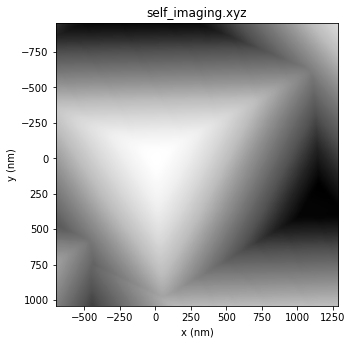

In [4]:
im1 = te.ImagePlot.from_hdf(image.output_file)
im1.save()

Analogously, an image of the Sobel-filtered data can be made using the `SobelPlot` class together with the `from_hdf()` class method. 

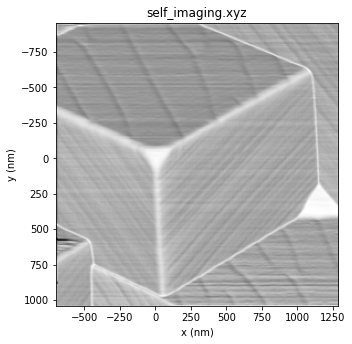

In [5]:
im2 = te.SobelPlot.from_hdf(image.output_file)
im2.save()

### Choosing the data for fitting
The core of the evaluation is a small user interface that is used for cropping the data to the required ranges. It can be started using the `run_data_selection()` function. In the program you then need to choose the file to load. Alternatively, the file path can be given as argument and it will be directly opened after opening the window. 

In [6]:
te.run_data_selection('output_example.h5')

The following image is a screenshot of the user interface. In order to crop the data to be able to subsequently fit it one needs to:
1. choose a maximum depth 
2. and a minimum depth to cut away the apex and the base of the tip
3. indicate where the edges of the pyramids are and choose an angular range to omit around the edges
4. use a region of interest in order to remove any additional tips that occur with self-imaging

In order to choose the minimum and maximum depths a slider can be moved changing the iso value displayed in the image. In order to set the values the two arrow buttons can be pressed. Additional "eye buttons" can be pressed in order to display/hide certain indicators in the image.

<img src="images\screenshot1.png" style="width: 500px;">

In order to indicate the edges of the pyramid double clicks need to be performed in the image at the required positions (which is somewhere on the edge). This will generate a line from the tip's apex to the clicked point. A region (in degrees) around the edge can be choosen. This region will be removed during the evaluation to avoid any influences from the edges. 

<img src="images\screenshot2.png" style="width: 500px;">

Lastly, a region of interest can be selected to crop the data only to the part of the image that has to be evaluated. This is optional but has to be performed for self-imaging measurements where additional tip images need to be removed. 

<img src="images\screenshot3.png" style="width: 500px;">

### Fitting the data
After the data has been cropped and saved to the hdf5 file (this can be done by just exiting the GUI via the 'Exit' button or by pressing the save limits/corners/ROI data buttons) the actual fit has to be performed. The way this is done is to make a Tip object from the previous hdf5 file. For the different tips there are several classes. Up to now, only the three sided pyramid is implemented including the Berkovich tip and the cube corner. They can be generated by the use of the `BerkovichTip` and `CubeCornerTip` classes. Both have a class method `from_file()` that automatically makes the fit from the saved data.

In [7]:
tip = te.BerkovichTip.from_file(image.output_file, name='example tip')

In order to plot the fit, `BerkovichTip` has a method `plot_fit_from_file()` which will load the necessary data. If `save_fig` is set to `True` the fit will automatically be saved. Alternatively, if it is set to `False` the image can also be saved from the window that opens. 

In [8]:
plot = tip.plot_fit_from_file(save_fig=True)

### Fitting the area function
Next we want to determine the depth-dependent cross-section of the tip. To do that, we need to first define the depths we want to calculate the cross-sections for. The best thing is to use a `numpy.linspace`. Also, two or more linspaces can be combined, as in the following example. This is useful in order to have different resolutions e.g. closer to the apex and farther away from it. If there is no closed contour available at a certain distance (either because there is not enough data or because the central point is not contained) a warning is issued. Then this depth is simply not added. The `calculate_cross_sections` method determines the cross sections for given distances. A plot is shown which can be saved.  

Distances:
 [  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  30.  40.  50.  60.
  70.  80.  90. 100. 110. 120. 130. 140. 150.]


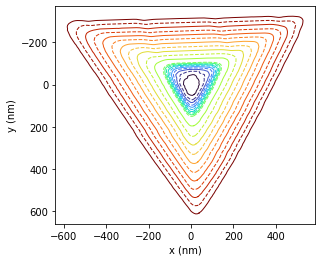

In [9]:
import numpy as np

distances1 = np.linspace(2, 18, 9)
distances2 = np.linspace(20, 150, 14)
distances = np.append(distances1, distances2)
print('Distances:\n', distances)

tip.calculate_cross_sections(distances, save_plot=True)

The actual fit of the area is performed using `fit_area_function()`. The required arguments are the number of coefficients to use for the fit (the maximum number is 6) and whether the first coefficient (which is the coefficient of the term proportional to the depth²) should be fixed to the ideal value for a pyramid with the given equivalent cone angle. For the Berkovich case, this coefficient is around 24.5. Additionally it is possible to specify whether the area should be displayed as the ratio to the ideal one or just the area. As always, the plot can be directly saved.  

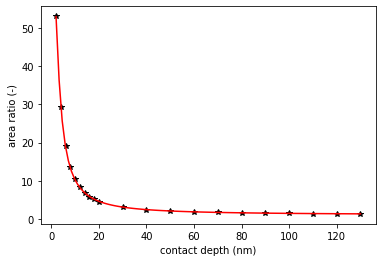

In [10]:
tip.fit_area_function(6, fix_first_coeff=True, plot_ratio=True, save_plot=True)

### Saving the tip object
It might be useful to save the complete tip object so that it can be later retrieved. In order to do that the `save_to_file()` method is available. This will serialize the tip instance and save the resulting binary stream in the same hdf5 file where the other data is saved as well. The tip can then later be retrieved by using the `load_tip_from_hdf()` function which takes the file path as input argument.  As you can see, after loading the tip we can apply the same methods as before (here we do not display the area ratio but directly the area). 

In [11]:
tip.save_to_file()  # save the serialized tip to the file

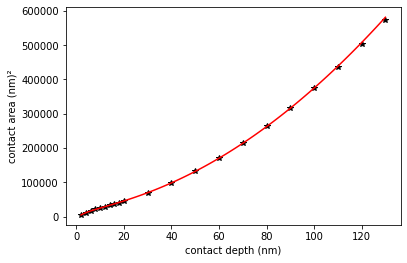

In [12]:
tip = te.load_tip_from_hdf(image.output_file)   # de-serializing the tip from the file
tip.fit_area_function(6, fix_first_coeff=True, plot_ratio=False)

### Determining the tip radius
For the determination of the tip radius we have four possibilities (see the associated paper for more details). 
#### fitting the tip radius
In order to determine the radius from a fit of the top part of the tip the `radius_fit()` method is available. It takes the depth value up to which the data points should be used. So, for a value of 20 all data points that are in the top 20 nm of the tip will be used. The recommendation of the paper is to use the depth at which the tip transitions from a sphere to a pyramid. This depth can be retrieved using `depth_sphere_transition()`. The procedure of determining this depth involves the Newton method for root-determination which is quite sensitive to an initial estimation of the tip radius. This method might not converge for badly chosen starting values. Therefore, it might be required to repeatedly call the method with different initial guesses.

`radius_fit()` returns the estimated radius value and the fit error. The fit will be displayed as a 3D mayavi plot. 

<img src="images\fit_radius.png" style="width: 300px;">

In [13]:
radius, error = tip.radius_fit(tip.depth_sphere_transition(radius_guess=100))
radius

567.1894181037303

#### Determine the radius from the area function
According to the book "Nanoindentation" from Fischer-Cripps, pages 86-89, the radius can be determined from the knowledge of the sphere-pyramid transition depth and the equivalent cone angle. The evaluation is performed using the `radius_from_area_function()` method. This method uses `depth_sphere_transition()` and consequently also needs a good starting value. `radius_from_area_function()` does only return an estimated radius value but no error. 

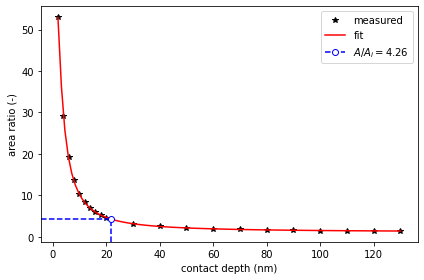

370.207655349634

In [14]:
tip.radius_from_area_function(radius_guess=100, save_plot=True)

#### Fitting a circle to the contact radius
The contact radius is the radius of a circle with the same area as the nanoindentation tip's cross section. For a sphero-conical indenter, the top region of the contact radius will follow a circle. When we fit this circle to the data we can estimate the tip radius. For a cone, the depth-dependent contact radius follows a line. Fitting this line gives an estimation of the equivalent cone angle. The evaluation is performed using `radius_from_contact_radius` which takes two arguments, a depth limit for the radius fit and a depth limit for the cone fit. The return values are the estimation of radius + fit error and cone angle + fit error (in degrees). Again, the plot can be directly saved.  

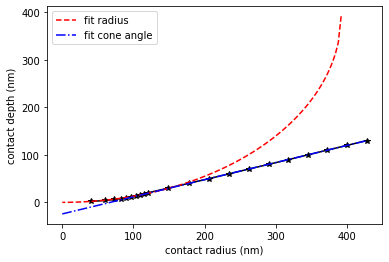

(391.64931653371997, 72.40454534650632, 70.17326122324317, 0.03619594124761059)

In [15]:
tip.radius_from_contact_radius(limit_radius=30, limit_cone_angle=100, save_plot=True)

#### Determination from blunting depth
The blunting depth of a tip is the distance between the actual apex of the tip and the intersection of the fitted planes, termed $h_b$ in the following image. Under the assumption of a sphero-conical indenter this distance allows to estimate the radius as well. The radius is automatically estimated when the `BerkovichTip` is instantiated and can be accessed via the `radius_blunting_depth` attribute.

<img src="images\fit_tip.png" style="width: 250px;">

In [16]:
tip.radius_blunting_depth

399.2250627542103

### Saving the area function to a file
Of course, the ultimate goal is to have an area function that can be used for evaluating nanoindentation measurements. Up to now it is possible to save area function files for Hysitron and Umis nanoindenters. To save a file, you need to use `save_area_function` supplying a file name and the system, either being `'Hysitron'` or `'UMIS'`. 

In [17]:
tip.save_area_function('MGB1-2105228_001 TF_AF.ara', system='Hysitron')

### Additional remarks
Additional information can be retrieved from the associated attributes and methods. To get an overview of the fit use `fit_info()`. 

In [18]:
print(tip.fit_info())

             Method              |  Value   |  Ideal value  
+++++++++++++++++++++++++++++++++|++++++++++|+++++++++++++++
   Tip axis inclination angle    |   1.2    |      0.0      
     Angle between face/axis     |   65.8   |     65.3      
                                 |   65.9   |     65.3      
                                 |   63.6   |     65.3      
 Tip angle (average face angle)  |   65.1   |     65.3      
     Cone angle pyramid fit      |   70.2   |     70.2      
    Cone angle contact radius    |   70.2   |     70.2      


The displayed values are saved in corresponding attributes: `axis_inclination_angle`, `angles_faces`, `tip_angle`, `equivalent_cone_angle` and `equivalent_cone_angle_fit_contact_radius`. So for instance to access the angles of the fit faces with the tip's axis, you have to write `tip.angles_faces`.

In [19]:
tip.angles_faces

[65.81770726894891, 65.87884350146996, 63.62537852851403]

There is also a graphical user interface under construction that is supposed to include the whole evaluation. Unfortunately, it is currently not complete. Nevertheless you can have a look at it by starting it with the following function:

In [ ]:
te.user_interface()

Finally, if you have any troubles just start the evaluation again from the beginning. This often helps. 

If you don't see any silver lining then feel free to contact me at my private email address: christian_saringer@gmx.net 